In [2]:
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [3]:
# Set up some global variables
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)

Using device:  /device:GPU:0


# Data preprocessing and parameters

In [4]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size

x_train = x_train.astype('float32') / 255. # Nawid - Divides the values by 255
x_test = x_test.astype('float32') / 255.
x_train =np.reshape(x_train, [-1, image_size, image_size, 1])
x_test =np.reshape(x_test, [-1, image_size, image_size, 1])


# Nawid - Noisy version of the testing and training data for denoising purposes
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# network parameters
input_shape = (28,28,1)
intermediate_dim = 64
batch_size = 128
latent_dim = 32
epochs = 5
conv_filters = 16
conv_kernel_size = 3

# Encoder architecture

In [5]:
class Sampling(tf.keras.layers.Layer): # Nawid - Specifies a custom layer
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

  def call(self, inputs):
    z_mean, z_log_sigma = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim)) # Nawid - Initalised random values with a mean of 0 and a standard deviation of 1
    return z_mean + tf.exp(0.5 * z_log_sigma) * epsilon

#z = Sampling()((z_mean, z_log_sigma)) # Nawid - Instantiates the custom layer and gets the output of the custom layer which is the value of z


In [6]:
class Encoder(tf.keras.layers.Layer): # Nawid - This defines the layer for the encoder
  def __init__(self, num_filters = conv_filters, num_kernel_size= conv_kernel_size, latent_dim=32, intermediate_dim = 64):
    super(Encoder, self).__init__()
    self.Conv1 = tf.keras.layers.Conv2D(filters = num_filters, kernel_size = num_kernel_size, activation ='relu', strides = 2, padding = 'same')
    self.Conv2 = tf.keras.layers.Conv2D(filters = 2*num_filters, kernel_size = num_kernel_size, activation ='relu', strides = 2, padding = 'same')
    self.Flatten  = tf.keras.layers.Flatten()

    self.Dense1 = tf.keras.layers.Dense(intermediate_dim, activation='relu')
    self.Dense_mean = tf.keras.layers.Dense(latent_dim)
    self.Dense_log_var = tf.keras.layers.Dense(latent_dim)
    self.sampling = Sampling() # Nawid-  This instantiates the sampling layer for the encoder

  def call(self,inputs):
    x1 = self.Conv1(inputs)
    x1 = self.Conv2(x1)

    self.conv_shape = tf.keras.backend.int_shape(x1) # Nawid - This gets the shape which is required for the decoding when using the conv2D transpose
    flattened_x1 = self.Flatten(x1)

    flattened_intermediate = self.Dense1(flattened_x1)
    z_mean = self.Dense_mean(flattened_intermediate)
    z_log_var = self.Dense_log_var(flattened_intermediate)
    z = self.sampling((z_mean, z_log_var))
    return z_mean,z_log_var, z#, conv_shape # Nawid-  Need to output the z variables as well as the shape for the decoder




# Instantiating the encoder 
Required to access shape variable required

In [8]:
x = tf.keras.layers.Input(shape=(image_size,image_size,1))  # Nawid - Input layer
encoder = Encoder() # Nawid - Instantiates encoder layer which is required to find the shape property
z_mean, z_log_var, z = encoder(x)
shape = encoder.conv_shape

encoder_model = tf.keras.Model(x,z)
encoder_model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Encoder)            ((None, 32), (None, 32),  109376    
Total params: 109,376
Trainable params: 109,376
Non-trainable params: 0
_________________________________________________________________


# Decoder architecture

In [9]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self,conv_shape = shape, num_filters = conv_filters, num_kernel_size= conv_kernel_size, latent_dim=32, intermediate_dim = 64): # Nawid - Need to put the shape of post convolution into the parameters
    super(Decoder,self).__init__()
    self.Dense_intermediate = tf.keras.layers.Dense(intermediate_dim, activation='relu')
    self.Dense_original = tf.keras.layers.Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation ='relu') # Nawid - Need to use the shape from the encoder
    self.Reshape = tf.keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3])) # Nawid - Need to reshape to the shape after the convolution
    self.Conv_transpose1 = tf.keras.layers.Conv2DTranspose(filters =num_filters, kernel_size = num_kernel_size, activation ='relu', strides=2, padding='same') # Nawid- Convolutional transpose steps to get back to original shape
    self.Conv_transpose2 = tf.keras.layers.Conv2DTranspose(filters =num_filters//2, kernel_size = num_kernel_size, activation ='relu', strides=2, padding='same')
    self.Conv_transpose3 = tf.keras.layers.Conv2DTranspose(filters =1, kernel_size = num_kernel_size, activation ='sigmoid',padding = 'same')

  def call(self, inputs):
    x1= self.Dense_intermediate(inputs)
    x1 = self.Dense_original(x1)
    x_pre_conv_transpose = self.Reshape(x1)
    x_conv_transpose= self.Conv_transpose1(x_pre_conv_transpose)
    x_conv_transpose = self.Conv_transpose2(x_conv_transpose)
    x_reconstruct = self.Conv_transpose3(x_conv_transpose)
    return x_reconstruct


# VAE instantiation

In [10]:
output = Decoder()(z)

vae =tf.keras.Model(x, output)
vae.summary()

decoder_input = tf.keras.layers.Input(shape = (latent_dim))
decoder_layer = vae.layers[-1]
decoder_output = decoder_layer(decoder_input)

decoder_model = tf.keras.Model(decoder_input, decoder_output)
decoder_model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Encoder)            ((None, 32), (None, 32),  109376    
_________________________________________________________________
decoder (Decoder)            (None, 28, 28, 1)         109889    
Total params: 219,265
Trainable params: 219,265
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
decoder (Decoder)            (None, 28, 28, 1)         109889    
Total params: 109,889
Trainable para

In [13]:
def vae_loss(x, x_decoded_mean):
    xent_loss = tf.keras.losses.binary_crossentropy(tf.keras.backend.flatten(x), tf.keras.backend.flatten(x_decoded_mean))
    xent_loss *= original_dim
    #xent_loss = tf.keras.backend.mean(xent_loss)
    kl_loss = - 0.5 * tf.keras.backend.mean(1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='adam', loss=vae_loss,experimental_run_tf_function=False)
# Explanation for where experimental_run_tf comes from -  https://github.com/tensorflow/probability/issues/519 

#vae.compile(optimizer='adam', loss='binary_crossentropy', experimental_run_tf_function=False)

In [14]:
vae.fit(x_train_noisy, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 16s 267us/sample - loss: 214.6761 - val_loss: 147.7002
Epoch 2/5
60000/60000 [==============================] - 15s 254us/sample - loss: 131.3713 - val_loss: 119.9933
Epoch 3/5
60000/60000 [==============================] - 15s 254us/sample - loss: 116.6258 - val_loss: 112.4401
Epoch 4/5
60000/60000 [==============================] - 15s 255us/sample - loss: 111.2934 - val_loss: 108.8363
Epoch 5/5
60000/60000 [==============================] - 15s 252us/sample - loss: 108.1635 - val_loss: 106.4114


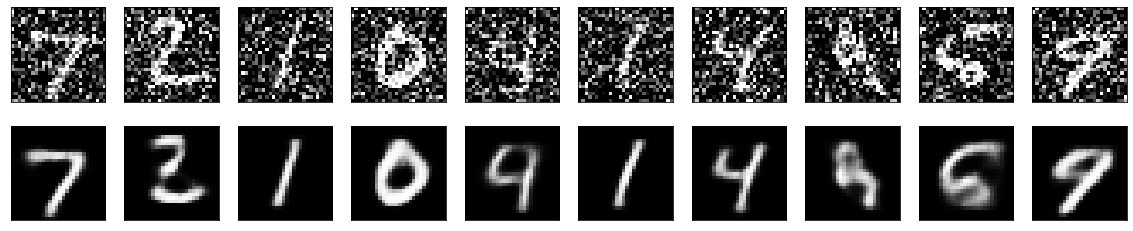

In [15]:
encoded_imgs = encoder_model.predict(x_test_noisy)
decoded_imgs = decoder_model.predict(encoded_imgs)
#decoded_imgs = vae.predict(x_test_noisy)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(10):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()